In [1]:
import numpy as np 
import pandas as pd 
import os
import SimpleITK as sitk
from scipy import ndimage
from math import floor,ceil

In [2]:
def volume(center, size):
    
    data = {}
    
    oz, oy, ox = center
    h, w, l = size

    x = np.linspace(ox-l/2,ox+l/2,num=10)
    y = np.linspace(oy-w/2,oy+w/2,num=10)
    z = np.linspace(oz-h/2,oz+h/2,num=10)
    
    data['x1'], data['z1'] = np.meshgrid(x, z)
    data['y11'] = np.ones_like(data['x1'])*(oy-w/2)
    data['y12'] = np.ones_like(data['x1'])*(oy+w/2)
    data['x2'], data['y2'] = np.meshgrid(x, y)
    data['z21'] = np.ones_like(data['x2'])*(oz-h/2)
    data['z22'] = np.ones_like(data['x2'])*(oz+h/2)
    data['y3'], data['z3'] = np.meshgrid(y, z)
    data['x31'] = np.ones_like(data['y3'])*(ox-l/2)
    data['x32'] = np.ones_like(data['y3'])*(ox+l/2)
    
    return data

In [3]:
def plot_cuboid(VOLUMES, axeslimits):

    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    for k, val in VOLUMES.items():
        color='g'
        if k=='patient':
            color='b'
        if k=='nodule':
            color='r'
        data = VOLUMES[k]
        ax.plot_wireframe(val['x1'], val['y11'], val['z1'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x1'], val['y12'], val['z1'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x2'], val['y2'], val['z21'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x2'], val['y2'], val['z22'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x31'], val['y3'], val['z3'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x32'], val['y3'], val['z3'], color=color, rstride=10, cstride=10, alpha=0.6)
    
    ax.set_xlim(np.max(axeslimits), 0)
    ax.set_xlabel('X')
    ax.set_ylim(0, np.max(axeslimits))
    ax.set_ylabel('Y')
    ax.set_zlim(0, np.max(axeslimits))
    ax.set_zlabel('Z')
    plt.show()

In [4]:
def voxels_nodule(DIRECTORY,PATIENT,DF,VIEWS=6,VOXEL_SIZE=64):

    itkimage = sitk.ReadImage('../data/'+DIRECTORY+PATIENT+'.mhd')
    img = sitk.GetArrayFromImage(itkimage)
    origin = np.array(list(reversed(itkimage.GetOrigin()))) # zyx
    spacing = np.array(list(reversed(itkimage.GetSpacing()))) # zyx

    # use only df rows pertaining to this patient
    DF['ix'] = range(DF.shape[0])
    dfsub = DF[DF['seriesuid']==PATIENT]

    # initialize list to hold voxels and corresponding indices
    trues = []
    falses = []
    trues_ix = []
    falses_ix = []
    count = 0
    dataset = {}

    # image coordinates if centered at zero
    img_max = img.shape*spacing
    dataset['patient'] = volume(list(img_max/2), list(img_max))

    # voxel shape with original image spacing
    voxel_shape = np.round(np.array([VOXEL_SIZE,VOXEL_SIZE,VOXEL_SIZE])/spacing)
    min_jitter = [ceil(m) for m in (voxel_shape/2)]
    max_jitter = [floor(m) for m in (img.shape-voxel_shape/2)]

    while count < max(VIEWS,VIEWS*dfsub.shape[0]):
        print ('\tView..',count+1)
        random_ZYX = np.array([np.random.randint(mi+1,ma-1) for mi,ma in zip(min_jitter,max_jitter)])
        print ('\t\tRandom center',random_ZYX)
        voxel_max = (random_ZYX + np.round(voxel_shape/2)).astype(int)
        voxel_min = (random_ZYX - (voxel_shape-np.round(voxel_shape/2))).astype(int)
        print ('\t\tRandom max and min',voxel_max,voxel_min)
        print ('\t\tRandom shape',voxel_max-voxel_min)

        voxel = img[voxel_min[0]:voxel_max[0],voxel_min[1]:voxel_max[1],voxel_min[2]:voxel_max[2]]
        print ('\t\tVoxel shape',voxel.shape)

        # now let's see if this voxel contains at least one nodule
        nodules = 0
        for nodule in range(dfsub.shape[0]):
            row = dfsub.iloc[nodule]
            nodule_ZYX = np.array([row['coordZ'],row['coordY'],row['coordX']])
            nodule_ZYX = np.round(np.absolute(nodule_ZYX-origin)/ spacing)

            if (nodule_ZYX<voxel_max).all() and (nodule_ZYX>voxel_min).all():
                nodules += 1

        if nodules==0:

            count += 1
            maxdiam_ix = -1

            dataset[count+1] = volume(list((voxel_min+voxel_shape/2)*spacing), list(voxel_shape*spacing))
            falses_ix.append(maxdiam_ix)

            # resize voxel spacing to 1mmx1mmx1mm
            voxel_norm = ndimage.interpolation.zoom(voxel,spacing,order=1,mode='nearest')
            voxel_norm = voxel_norm[0:64,0:64,0:64]

            print ('\t\tVoxel norm',voxel_norm.shape)
            voxel_norm = np.clip(voxel_norm, -1000, 400)
            print ('\t\tResized voxel shape',voxel_norm.shape)
            voxel_norm = np.transpose(voxel_norm, (2,1,0)) #X,Y,Z 
            falses.append(voxel_norm)
        else:
            print ('\t\t!Nodule found!')
            continue

    plot_cuboid(dataset, list(img_max))

    dataset = {}
    dataset['patient'] = volume(list(img_max/2), list(img_max))

    # for each nodule
    for nodule in range(dfsub.shape[0]):

        # set the row so that it's only referencing the nodule of choice
        row = dfsub.iloc[nodule]

        # grab diameter of nodule, divide by spacing to adjust to patient spacing
        nodule_rad = row['diameter_mm']/spacing/2

        # nodule coordinates based on original image origin
        nodule_ZYX = np.array([row['coordZ'],row['coordY'],row['coordX']])
        print ('Original nodule coords',nodule_ZYX)
        print ('\tOrigin',origin)

        # shift nodule coordinates to origin of 0 instead of image origin
        nodule_ZYX = np.absolute(nodule_ZYX-origin)
        print ('\tAdjusted to origin [0,0,0]',nodule_ZYX)

        # adjust coordinates such that reflective of patient array spacing
        nodule_ZYX = np.round(nodule_ZYX / spacing)
        print ('\tAdjusted for spacing and rounded',nodule_ZYX)

        # nodule volume limits
        nodule_max = np.array([ceil(c) for c in nodule_ZYX+nodule_rad])
        nodule_min = np.array([floor(c) for c in nodule_ZYX-nodule_rad])
        nodule_shape = nodule_max-nodule_min
        print ('Nodule shape',nodule_shape)

        dataset['nodule'] = volume(list(nodule_ZYX*spacing), list(nodule_shape*spacing))

        # set max value of movement around nodule
        max_jitter = np.amin(np.stack((abs(nodule_max-img.shape),voxel_shape-nodule_shape)),axis=0)
        print ('Max Jitter',max_jitter)

        # set min value of movement around nodule
        min_jitter = nodule_min-max_jitter
        min_jitter[min_jitter > 0.] = 0.
        min_jitter = np.abs(min_jitter)
        print ('Min Jitter',min_jitter)

        print ('Number of views..',VIEWS)
        #for the number of views, grab voxel around nodule
        for i in range(VIEWS):
            print ('\tView..',i+1)
            jitter = np.array([np.random.randint(mi+1,ma-1) for mi,ma in zip(min_jitter,max_jitter)])
            voxel_max = nodule_max + jitter
            voxel_min = (nodule_min - (voxel_shape-nodule_shape-jitter)).astype(int)
            print ('\t\tVoxel coords',voxel_max,voxel_min)
            print ('\t\tVoxel max-min',voxel_max-voxel_min)

            voxel = img[voxel_min[0]:voxel_max[0],voxel_min[1]:voxel_max[1],voxel_min[2]:voxel_max[2]]
            print ('\t\tVoxel shape',voxel.shape)

            # now let's see if this voxel contains more than one nodule
            maxdiam_ix = -1
            maxdiam = 0
            for nodule in range(dfsub.shape[0]):
                row = dfsub.iloc[nodule]
                nodule_ZYX = np.array([row['coordZ'],row['coordY'],row['coordX']])
                nodule_ZYX = np.round(np.absolute(nodule_ZYX-origin)/ spacing)

                if (nodule_ZYX<voxel_max).all() and (nodule_ZYX>voxel_min).all():
                    if row['diameter_mm'] > maxdiam:
                        maxdiam_ix = row['ix']
                        maxdiam = row['diameter_mm']

            dataset[i] = volume(list((voxel_min+voxel_shape/2)*spacing), list(voxel_shape*spacing))
            trues_ix.append(maxdiam_ix)

            # resize voxel spacing to 1mmx1mmx1mm
            voxel_norm = ndimage.interpolation.zoom(voxel,spacing,order=1)
            voxel_norm = voxel_norm[0:64,0:64,0:64]
            print ('\t\tVoxel norm',voxel_norm.shape)
            voxel_norm = np.clip(voxel_norm, -1000, 400)
            print ('\t\tResized voxel shape',voxel_norm.shape)
            voxel_norm = np.transpose(voxel_norm, (2,1,0)) #X,Y,Z 
            trues.append(voxel_norm)

        plot_cuboid(dataset, list(img_max))

    falses_array = np.stack(falses)
    falses_ix_array = np.array(falses_ix).astype('int32')
    if dfsub.shape[0]>0:
        trues_array = np.stack(trues)
        trues_ix_array = np.array(trues_ix).astype('int32')
        return trues_array,trues_ix_array,falses_array,falses_ix_array
    else:
        return falses_array,falses_ix_array

In [5]:
df = pd.read_csv('../data/CSVFILES/annotations_enhanced.csv')
patient = '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059'
directory = 'subset0/'

	View.. 1
		Random center [ 36 290 318]
		Random max and min [ 62 348 376] [ 11 231 259]
		Random shape [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 2
		Random center [104 396 351]
		Random max and min [130 454 409] [ 79 337 292]
		Random shape [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 3
		Random center [ 32 220  85]
		Random max and min [ 58 278 143] [  7 161  26]
		Random shape [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 4
		Random center [ 49 396 193]
		Random max and min [ 75 454 251] [ 24 337 134]
		Random shape [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 5
		Random center [133 443 438]
		Random max and min [159 501 496] [108 384 379]
		Random shape [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64,

/home/gantos/.local/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


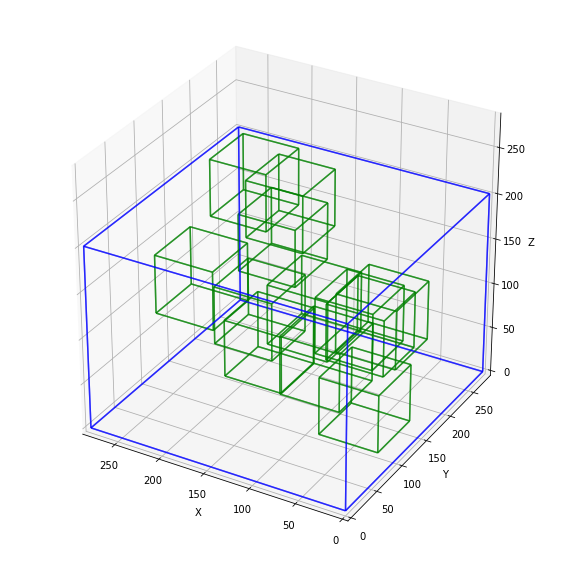

Original nodule coords [-108.5786324    48.40280596   46.18853869]
	Origin [-194.       -108.300003 -187.699997]
	Adjusted to origin [0,0,0] [  85.4213676   156.70280896  233.88853569]
	Adjusted for spacing and rounded [  68.  286.  426.]
Nodule shape [12 26 26]
Max Jitter [ 39.  91.  73.]
Min Jitter [ 0.  0.  0.]
Number of views.. 6
	View.. 1
		Voxel coords [ 93 353 499] [ 42 236 382]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 2
		Voxel coords [100 372 440] [ 49 255 323]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 3
		Voxel coords [ 85 333 500] [ 34 216 383]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 4
		Voxel coords [ 80 355 507] [ 29 238 390]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resiz

/home/gantos/.local/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


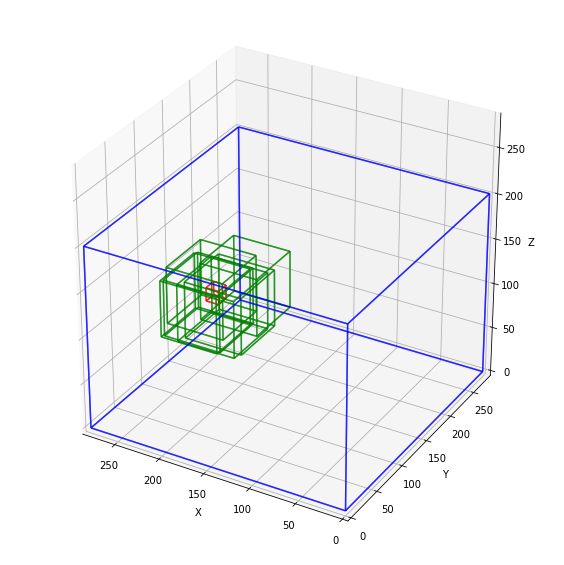

Original nodule coords [-123.3219112    76.77166265   36.39204443]
	Origin [-194.       -108.300003 -187.699997]
	Adjusted to origin [0,0,0] [  70.6780888   185.07166565  224.09204143]
	Adjusted for spacing and rounded [  57.  337.  408.]
Nodule shape [4 8 8]
Max Jitter [  47.  109.  100.]
Min Jitter [ 0.  0.  0.]
Number of views.. 6
	View.. 1
		Voxel coords [ 72 409 448] [ 21 292 331]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 2
		Voxel coords [ 64 389 437] [ 13 272 320]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 3
		Voxel coords [ 83 410 430] [ 32 293 313]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 4
		Voxel coords [102 435 478] [ 51 318 361]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resiz

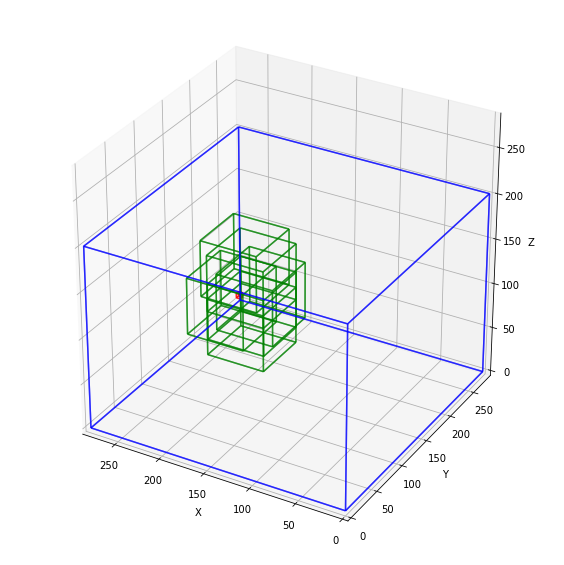

In [6]:
results = voxels_nodule(directory,patient,df)